# Prueba Coink - Cientifico de Datos
En este Jupyter Notebook se desarrollan los 3 puntos de la prueba Coink para el cargo Cientifico de Datos con fecha de entrega domingo 19 de marzo 2023. Además del enunciado, para la realizar la prueba se necesitan dos datasets que estan contenidos en el folder resources

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

### Punto 1
En este punto piden evaluar que tan buenos son los usuarios de Coink y calificar a los usuarios contenidos en la muestra **depositos_oink.csv**. Lo primero es cargar los datos para hacer una primera exploración

In [2]:
# Lee el .csv de resources. La primera columna (Unnamed: 0) son indices
depositos_oink_df = pd.read_csv("resources\depositos_oinks.csv", index_col = 'Unnamed: 0')

# Cast de las columnas que contienen fechas. Se hace para mejor operabilidad
# Convierte la fecha en un delta de tiempo igual al tiempo transcurrido desde la fechas hasta la actualidad
now = datetime.now()
for col in ['operation_date', 'user_createddate']:
    depositos_oink_df[col] = (now - pd.to_datetime(depositos_oink_df[col]))

depositos_oink_df.head(5)

,user_id,operation_value,operation_date,maplocation_name,user_createddate
0,0e52d550-ae23-407a-9b1f-6e5fb1f066ab,273850.0,429 days 03:05:46.903054,CC Plaza de las Américas - Plaza Mariposa,433 days 20:50:24.570365
1,975ed41e-d891-4c23-aeba-06363019d8e3,900.0,406 days 03:02:17.903054,CC Plaza de las Américas - Plaza Mariposa,433 days 00:54:13.483979
2,f9043545-dfc2-402f-a8c7-0a61f21cb719,1800.0,389 days 02:11:46.903054,Universidad de los Andes - ML Piso 5,571 days 03:28:54.378113
3,979ca8ad-9600-4a1f-81e9-e70c2f55cdc5,6500.0,458 days 04:03:57.903054,CC Plaza de las Américas - Plaza Mariposa,609 days 23:02:26.136763
4,171db06e-2e4b-4542-a9c9-32028520fda4,150000.0,418 days 04:13:24.903054,CC Plaza de las Américas - Plaza Mariposa,432 days 00:14:15.251060


La métrica para calificar usuarios (user_score) propuesta se describe a continuación.

$$user\_score = C_{monto}+C_{recurrencia}$$
$user score$ es la suma de dos coeficientes que miden aspectos distintos en la importancia del usuario. Por un lado $C_{recurrencia}$ cuantifica la recurrencia con la que la persona hace depositos. Adicional, $C_{monto}$ cuantifica el tamaño de los depositos.

In [3]:
## Agrupación del dataset por usuarios

# Diccionario de agrupacion. Se define la extraccion las siguientes variables
# - La primera y ultima fecha de transaccion
# - La fecha de creacion del usuario
# - El numero de transacciones
# - Monto total de las transferencias
agg_dict = {'operation_date': ['min', 'max'], 'user_createddate': 'first', \
            'user_id': 'count', 'operation_value' : 'sum'}

# Agrupacion por user_id
grouped_df = depositos_oink_df.groupby('user_id').agg(agg_dict)

grouped_df.head()

operation_date  \
                                                          min   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 391 days 02:59:49.903054   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 417 days 06:54:07.903054   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 458 days 20:08:28.903054   
0072157e-a634-4cb3-bead-b1a2981485ca 407 days 04:47:16.903054   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 399 days 21:19:55.903054   

                                                               \
                                                          max   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 407 days 03:13:37.903054   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 417 days 06:54:07.903054   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 458 days 21:35:55.903054   
0072157e-a634-4cb3-bead-b1a2981485ca 421 days 04:54:16.903054   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 399 days 21:19:55.903054   

                                             user_createddate user_id  \
                                                        first   count   
user_id                                                                 
001762e3-094d-415c-9304-c7c182e0c16a 496 days 04:07:07.355779       3   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 480 days 07:49:46.500837       1   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 718 days 23:26:34.284467       4   
0072157e-a634-4cb3-bead-b1a2981485ca 430 days 05:23:54.202474      10   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 461 days 04:32:09.833267       1   

                                     operation_value  
                                                 sum  
user_id                                               
001762e3-094d-415c-9304-c7c182e0c16a         44750.0  
002a5f4d-a93d-4cc5-b089-e16169bc16a2        259000.0  
006687d3-8ff3-461e-bdac-cb8e8e4c5a26        375600.0  
0072157e-a634-4cb3-bead-b1a2981485ca        433450.0  
0082af19-8bf7-46f7-8a21-c34e46ac5e2a          1500.0

Específicamente, $C_{recurrencia}$ se define como el tiempo promedio entre cada operación. La idea es que entre menor sea el tiempo promedio entre transacciones el usuario puntue más alto. Adicionalmente, se divide dicho promedio entre el tiempo de creación de la cuenta más vieja de la muestra. La división se hace para que $C_{recurrencia}$ quede en numeros adimensionales y se prioricen las personas más antiguas en caso de tiempos promedios entre transacciones similares.


A continuación se calcula el $C_{recurrencia}$ de cada usuario. Como se menciono, está definido como:
$$
C_{recurrencia}=\frac{\hat{\Delta t}}{Tiempo\ de\ creación\ usuario}
$$
Donde $\hat{\Delta t}$ es el tiempo promedio entre transacciones que se puede calcular como
$$
\hat{\Delta t}=\frac{(t_1-t_2)+(t_2-t_3)+...+(t_{n-1}-t_n)}{número\ de\ transacciones}=\frac{t_1-t_n}{número\ de\ transacciones}
$$
Donde $t_i$ es la fecha de la transacción $i$

In [4]:
## Calculo de c_recurrencia
grouped_df['c_recurrencia'] = (grouped_df[('user_createddate', 'first')] - grouped_df[('operation_date', 'min')] \
    / grouped_df[('user_id', 'count')]) / grouped_df[('user_createddate', 'first')]

grouped_df.head()

operation_date  \
                                                          min   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 391 days 02:59:49.903054   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 417 days 06:54:07.903054   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 458 days 20:08:28.903054   
0072157e-a634-4cb3-bead-b1a2981485ca 407 days 04:47:16.903054   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 399 days 21:19:55.903054   

                                                               \
                                                          max   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 407 days 03:13:37.903054   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 417 days 06:54:07.903054   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 458 days 21:35:55.903054   
0072157e-a634-4cb3-bead-b1a2981485ca 421 days 04:54:16.903054   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 399 days 21:19:55.903054   

                                             user_createddate user_id  \
                                                        first   count   
user_id                                                                 
001762e3-094d-415c-9304-c7c182e0c16a 496 days 04:07:07.355779       3   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 480 days 07:49:46.500837       1   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 718 days 23:26:34.284467       4   
0072157e-a634-4cb3-bead-b1a2981485ca 430 days 05:23:54.202474      10   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 461 days 04:32:09.833267       1   

                                     operation_value c_recurrencia  
                                                 sum                
user_id                                                             
001762e3-094d-415c-9304-c7c182e0c16a         44750.0      0.737238  
002a5f4d-a93d-4cc5-b089-e16169bc16a2        259000.0      0.131241  
006687d3-8ff3-461e-bdac-cb8e8e4c5a26        375600.0      0.840454  
0072157e-a634-4cb3-bead-b1a2981485ca        433450.0      0.905352  
0082af19-8bf7-46f7-8a21-c34e46ac5e2a          1500.0      0.132918

Para estimar $C_{monto}$, simplemente se aplica un escalamiento min-max. Esto se hace para que el coeficiente quede en valores adimensionales y se le asigne un puntaje más alto a los que tienen más dinero transferido. Sin embargo, en un país con ingresos tan desiguales no sería justo una métrica directamente proporcional al ingreso de la persona. Para ilustrar el problema se realiza la siguiente gráfica:


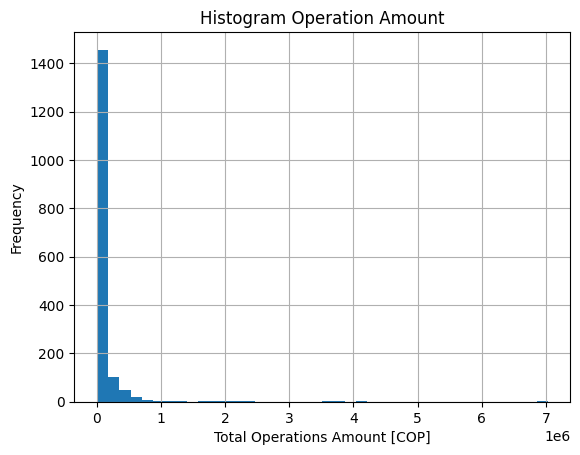

In [5]:
## Plot histograma del monto total de las transferencias de cada usuario
grouped_df[('operation_value', 'sum')].hist(bins = 40)

# Añade etiquetas y titulo
plt.xlabel('Total Operations Amount [COP]')
plt.ylabel('Frequency')
plt.title('Histogram Operation Amount')
plt.show()

En la figura de arriba se encuentra el histograma de los montos totales de cada usuario. Se observa un gran sesgo a la izquierda, lo que es esperado, pero también se observan unos outliers a la derecha de la grafica. Para corregir esto último se opta por aplicar una transformación a la variable del monto total de las transferencias.

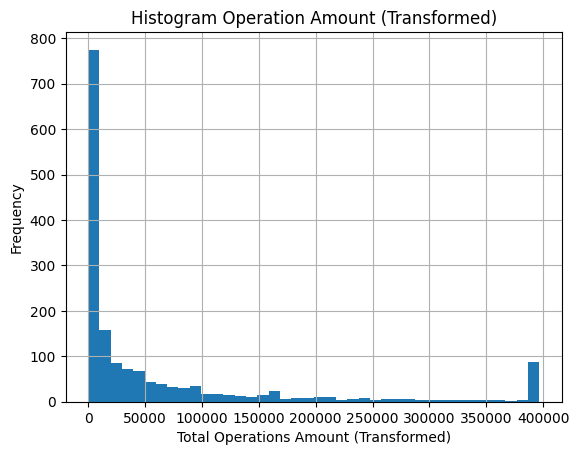

In [6]:
## Winsorizacion y comprobacion de la misma

from scipy.stats.mstats import winsorize

# Definine el rango (percentiles) del recorte. 
# Notese que a los que estan en este percentil van a tener la maxina calificacion
winsorize_percentile = 0.05

# Aplica Winsorization a la cola de arriba.
grouped_df['operation_trans'] = winsorize(grouped_df[('operation_value', 'sum')], limits=[None, winsorize_percentile])

## Plot histograma del monto total de las transferencias de cada usuario (transformado)
grouped_df['operation_trans'].hist(bins = 40)

# Añade etiquetas y titulo
plt.xlabel('Total Operations Amount (Transformed)')
plt.ylabel('Frequency')
plt.title('Histogram Operation Amount (Transformed)')
plt.show()

La distribucion de la variable creada no tiene los outliers de la anterior, sin embargo sigue respetando la distribución. Esta es la que se usa para el calculo de $C_{monto}$

In [7]:
bottom_value = grouped_df['operation_trans'].min()
top_value = grouped_df['operation_trans'].max()
grouped_df['c_monto'] = (grouped_df['operation_trans'] - bottom_value) / (top_value - bottom_value)


Por último, se calcula $user\_score$:

In [8]:
grouped_df['user_score'] = grouped_df['c_recurrencia'] + grouped_df['c_monto']

grouped_df.head()

operation_date  \
                                                          min   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 391 days 02:59:49.903054   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 417 days 06:54:07.903054   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 458 days 20:08:28.903054   
0072157e-a634-4cb3-bead-b1a2981485ca 407 days 04:47:16.903054   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 399 days 21:19:55.903054   

                                                               \
                                                          max   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 407 days 03:13:37.903054   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 417 days 06:54:07.903054   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 458 days 21:35:55.903054   
0072157e-a634-4cb3-bead-b1a2981485ca 421 days 04:54:16.903054   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 399 days 21:19:55.903054   

                                             user_createddate user_id  \
                                                        first   count   
user_id                                                                 
001762e3-094d-415c-9304-c7c182e0c16a 496 days 04:07:07.355779       3   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 480 days 07:49:46.500837       1   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 718 days 23:26:34.284467       4   
0072157e-a634-4cb3-bead-b1a2981485ca 430 days 05:23:54.202474      10   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 461 days 04:32:09.833267       1   

                                     operation_value c_recurrencia  \
                                                 sum                 
user_id                                                              
001762e3-094d-415c-9304-c7c182e0c16a         44750.0      0.737238   
002a5f4d-a93d-4cc5-b089-e16169bc16a2        259000.0      0.131241   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26        375600.0      0.840454   
0072157e-a634-4cb3-bead-b1a2981485ca        433450.0      0.905352   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a          1500.0      0.132918   

                                     operation_trans   c_monto user_score  
                                                                           
user_id                                                                    
001762e3-094d-415c-9304-c7c182e0c16a         44750.0  0.112793   0.850032  
002a5f4d-a93d-4cc5-b089-e16169bc16a2        259000.0  0.653419   0.784660  
006687d3-8ff3-461e-bdac-cb8e8e4c5a26        375600.0  0.947641   1.788095  
0072157e-a634-4cb3-bead-b1a2981485ca        396350.0  1.000000   1.905352  
0082af19-8bf7-46f7-8a21-c34e46ac5e2a          1500.0  0.003659   0.136577

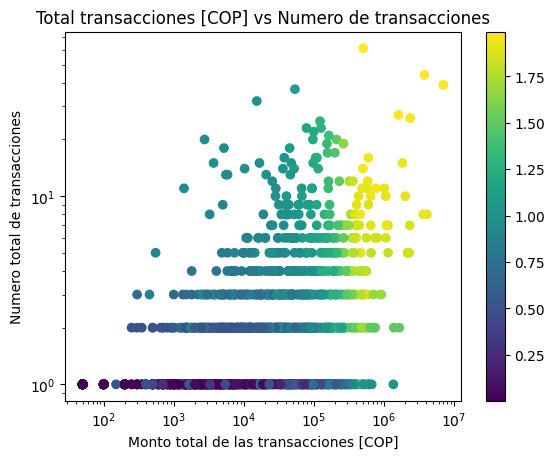

In [9]:
## Grafica monto total de las transacciones vs numero de de transacciones
plt.scatter(grouped_df[('operation_value', 'sum')], grouped_df[('user_id', 'count')], c=grouped_df['user_score'], cmap='viridis')

# Añade barra de colores
plt.colorbar()

# Añade etiquetas a los ejes y el titulo
plt.xlabel('Monto total de las transacciones [COP]')
plt.ylabel('Numero total de transacciones')
plt.title('Total transacciones [COP] vs Numero de transacciones')

# Rescala los ejes
plt.xscale('log')
plt.yscale('log')

# Muestra la grafica
plt.show()

En al figura de arriba se encuentra una grafica del monto total de las transacciones de cada usuario vs el numero de transacciones. Adicional, el color de los puntos está en función del puntaje alcanzado por el usuario. Se observa que entre mas monto total y entre mayor numero de transacciones el puntaje es mayor, tal y como se esperaba. Adicionalmente se observa una diferencia de color entre puntos similares de la grafica. Esto se debe a la influencia que tiene la varible de fecha de creacion de la cuenta en el puntaje del usuario. La relación es que entre más vieja sea la cuenta, más mayor número de transacciones necesita para tener un buen promedio.

Nota: Se puede añadir un peso a casa monto y asi darle prioridad a unas variables sobre otras, todo depende del concepto de bueno que se quiera modelar.

### Punto 2
En el punto 2 piden explicar en 300 palabras o menos como se haría el depliegue de un modelo de ML en AWS. Este debe ser ejecutado a demanda con un API.

A continuación se hace la descripción del despliegue de un modelo ya entrenado sin retroalimentación:

Lo primero es preparar los archivos en una carpeta para la continua integracion del modelo. Estos son:
- Modelo de ML entrenado
- Requerimientos.txt
- Codigo fuente (constructor)
- Dependencias o librerias
- Scripts de testing

Para nuestra aplicación Amazon S3 es perfecto para almacenar el modelo y todas sus dependencias.

Lo siguiente es importar el modelo a un servicio de despliegue como Amazon SageMaker. En este punto se especifica la ruta del modelo y el punto de enlance para permitir el uso de una API.

Para esta aplicacion, se puede optar por crear una API Rest con Amazon API Gateway. También toca definir la estructura y los endpoints. Se pueden utilizar los métodos HTTP (GET, POST, PUT, DELETE, etc.) para interactuar con el modelo. Por ejemplo, se puede enviar una solicitud POST con los datos de entrada y la API devolverá la predicción. 

Dependiendo de la complejidad del modelo, se puede hacer la integracion de la API Gateway con SageMaker en AWS Lambda o en EC2. AWS Lambda es mejor para modelos simples que no requieren mucha capacidad de procesamiento, mientras que Amazon EC2 es mejor para modelos más complejos. 

Adicionalmente, es necesario hacer las configuraciones de seguridad pertinentes de la API en Amazon Cognito. Se debe crear un grupo de usuarios en Cognito y asignar permisos de acceso a la API a ese grupo. Luego, se configura la autorización de la API en Amazon API Gateway para que sólo permita el acceso a los usuarios autenticados y autorizados.

Finalmente, ademas de dejar todo documentado es necesario probar la API y el modelo. Si tenemos todo continuamente integrado gran parte de este paso esta automatizado. También recomendable realizar pruebas de estabilidad, pruebas de carga y pruebas de seguridad para asegurarse de que la API funciona correctamente y es segura.

### Punto 3
En el punto 3 entrenar 2 modelos de apredizaje supervisado para predicir la variable JobSatisfaction del dataset info_satisfaccion_trabajo.xlsx. Adicionalmente, explicar en 150 palabras o menos como monitorear el modelo en caso de que estuviera desplegado para uso recurrente.

Primero se cargan los datos para un analisis preliminar

In [10]:
## Carga de los datos y primera limpieza
# Carga el excel
satisfaction_df = pd.read_excel("resources\info_satisfaccion_trabajo.xlsx")

# Se eliminan las columnas que son constantes
satisfaction_df = satisfaction_df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'])

# Muestra el numero de columnas que hay de cada tipo
print(satisfaction_df.dtypes.value_counts())

satisfaction_df.head(5)

int64     24
object     8
dtype: int64


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,3,4,1,6,3,3,2,2,2,2


Al observar el dataset se observan variables que no aportan ningun valor para predecir ya que son constantes (`EmployeeCount`, `Over18`, `StandardHours`), estas se eliminan de inmediato.

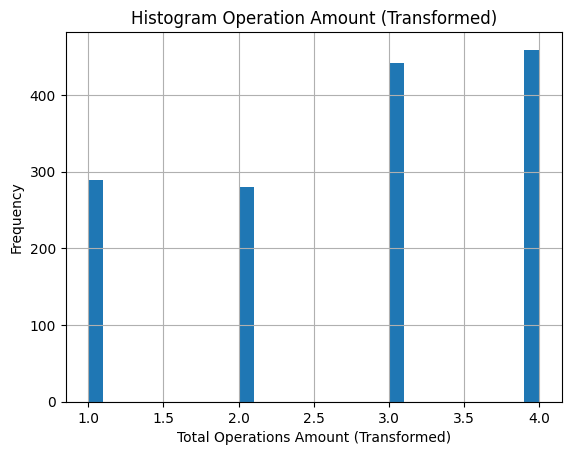

In [11]:
satisfaction_df['JobSatisfaction'].hist(bins = 30)

# Añade etiquetas y titulo
plt.xlabel('Total Operations Amount (Transformed)')
plt.ylabel('Frequency')
plt.title('Histogram Operation Amount (Transformed)')
plt.show()

La figura de arriba muestra el histograma de frecuencia de la variable a predecir. Se observa que hay una mayoria de niveles de satisfaccion 3 y 4. Esto es algo importante a tener en cuenta ya que no queremos que estas clases mayoritarias tengan mayor peso para el entrenamiento. 

 Adicionalmente se observan que el dataset contiene varios tipos de datos. Es decir, es necesario transformar el dataset para poner entrenar un modelo. Para este procedimiento se define la clase `CustomEncoder`. Esta cuenta con la funcion `transform()` que aplica las siguientes transformaciones:
- En nuestro caso, las columnas que son object (variables categoricas) type son codificadas con el metodo One Hot Encoder
- Las columnas numericas pero que tienen pocas opciones de respuesta se codifican como categorias ordinales
- Las columnas numericas faltantes rescalan de manera estandar

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

class CustomEncoder(BaseEstimator, TransformerMixin):
    '''Clase de codificador customisado
            - self (pd.DataFrame o pd.Series) : datset a ser transformado
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        ''' Transforma un dataframe o serie usando el codificador necesario para nuestra aplicacion
            Returns:
                - X_encoded (np.array) : encoded data
        '''

        # Si es una serie simplemente la codifica y retorna de inmediato
        if isinstance(X, pd.Series):
            return OrdinalEncoder().fit_transform(X.values.reshape(-1, 1))

        # Identificacion del tipo de transformacion que se le debe hacer a cada columna
        onehot_cols = []
        ordinal_cols = []
        scaling_cols = []
        for col in X.columns:
            columna = X[col]
            if col == 'TrainingTimesLastYear':
                scaling_cols.append(col)
                continue
            if X[col].dtype == 'object':
                onehot_cols.append(col)
            elif len(columna.unique()) <= 8:
                ordinal_cols.append(col)
            else:
                scaling_cols.append(col)

        # Se crea un objeto ColumnTransformer con las columnas ya clasificadas segun transformacion
        ct = ColumnTransformer(transformers = [('onehot', OneHotEncoder(), onehot_cols), 
                                               ('cardinal', OrdinalEncoder(), ordinal_cols),
                                               ('scaling', StandardScaler(), scaling_cols)],
                                               remainder='passthrough')

        # Aplica la transformacion al dataframe
        X_encoded = ct.fit_transform(X)

        return X_encoded


La variable `JobSatisfaction` representa el nivel de satisfaction del trabajador en una escala de 1 a 4. Esto significa que la variable a predecir es categorica pero tiene un orden a respetar, por consiguiente se codifican ordenadamente. Como la variable es categorica se usan algoritmos clasificadores.

Para el primer modelo se optó por Gradient Boosted Decision Trees (GBC). Ademas se ser clasificador, es de los mejores en terminos de precision, es barato en memoria, maneja diferentes tipos de datos y no requiere normalizar.

In [13]:
def gradient_boosting_classifier(df):
    """
        Entrena un red neuronal a partir de un dataframe
        Args:
            - df (pd.DataFrame) : dataset principal
        Returns:
            - grid (sklearn.model_selection.GridSearchCV) : fitted model
            - y_pred (pd.Series) : predicted values from X_test using the fitted model
            - y_test (pd.Series) : true values for X_test
    """

    from sklearn.model_selection import GridSearchCV, train_test_split
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.metrics import make_scorer, recall_score
    from sklearn.pipeline import Pipeline

    # Se especifica la variable a predecir y se separa del resto del dataset
    variable_pred = 'JobSatisfaction'
    X = df.drop(variable_pred, axis=1)
    y = df[variable_pred]

    # Separacion de los datos para entrenar y para testear
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    # Metrica a optimizar para la obtencion de hiperparametros
    scorer = make_scorer(recall_score, average='micro', labels=[1, 2])

    # Crea el pipeline para el Grid Search
    pipe = Pipeline([
        ('encoder', CustomEncoder()),
        ('classifier', GradientBoostingClassifier(random_state=0))
    ])

    # Creacion de un objeto Grid para optimizacion de hiperparametros
    param_grid = {'classifier__learning_rate' : [0.01, 0.1, 0.5, 1],
                  'classifier__n_estimators' : [5, 10, 20, 50],
                  'classifier__max_depth': [3, 4, 7, 10, 15]}
    grid = GridSearchCV(pipe, param_grid, n_jobs = -1,  error_score="raise", scoring = scorer)

    # Entrenamiento del modelo y optimizacion de hiperparametros
    grid.fit(X_train, y_train)

    # Prediccion del modelo con los datos de testeo
    y_pred = grid.predict(X_test)

    # Metricas
    print('Grid best params: ', grid.best_params_)
    print('Grid best score: ', grid.best_score_)
    
    return grid, y_test, y_pred

Grid best params:  {'classifier__learning_rate': 1, 'classifier__max_depth': 3, 'classifier__n_estimators': 20}
Grid best score:  0.2121751025991792
Accuracy (Test) 0.28804347826086957
Recall Micro Class 1, 2 (Test) 0.17142857142857143


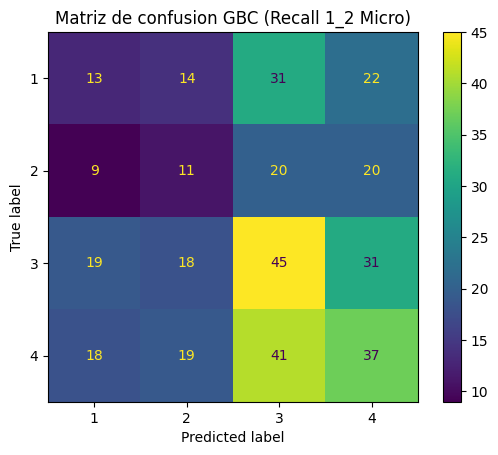

In [14]:
grid, y_test, y_pred = gradient_boosting_classifier(satisfaction_df)

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, ConfusionMatrixDisplay

# Metricas
print('Accuracy (Test)', accuracy_score(y_test, y_pred))
print('Recall Micro Class 1, 2 (Test)', recall_score(y_test, y_pred, average = 'micro', labels=[1, 2]))

# Creacion de la matriz de confusion
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels = labels)

# Graficar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot()
plt.title('Matriz de confusion GBC (Recall 1_2 Micro)')
plt.show()

Para el segundo modelo se eligió como algoritmo una red neuronal. Se optó por una red neuronal por su capacidad de detectar patrones complejos y su tolerancia al ruido. El preprocesamiento de los datos es el mismo pero adicionalmente para las redes neuronales se decicidió usar un `RandomOverSampler` para que todas las clases tengan el mismo peso. Tener en cuenta que por esto el puntaje alcanzado durante el entrenamiento por el grid search es mas alto que en el testing. También hay que tener en cuenta de que el modelo funciona mejor para unas clases que para otras entonces la metrica de calificacion en el test set cambia si la distribucion de clases de este set cambia.

In [15]:
def neural_network(df):
    """
        Entrena un red neuronal a partir de un dataframe
        Args:
            - df (pd.DataFrame) : dataset principal
        Returns:
            - grid (sklearn.model_selection.GridSearchCV) : fitted model
            - y_pred (pd.Series) : predicted values from X_test using the fitted model
            - y_test (pd.Series) : true values for X_test
    """

    from sklearn.model_selection import GridSearchCV, train_test_split
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import make_scorer, recall_score
    from sklearn.pipeline import Pipeline
    from imblearn.over_sampling import RandomOverSampler

    # Se especifica la variable a predecir y se separa del resto del dataset
    variable_pred = 'JobSatisfaction'
    X = df.drop(variable_pred, axis=1)
    y = df[variable_pred]

    # Separacion de los datos para entrenar y para testear
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    # Resampling del test set
    ros = RandomOverSampler(random_state=0)
    X_train, y_train = ros.fit_resample(X_train, y_train)

    # Metrica a optimizar para la obtencion de hiperparametros
    scorer = make_scorer(recall_score, average='micro', labels=[1, 2])

    # Crea el pipeline para el Grid Search
    pipe = Pipeline([
        ('encoder', CustomEncoder()),
        ('classifier', MLPClassifier(random_state=0))
    ])

    # Creacion de un objeto Grid para optimizacion de hiperparametros
    param_grid = {
        'classifier__hidden_layer_sizes': [(25,), (50,), (100,), (50, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__solver': ['adam', 'sgd'],
        'classifier__learning_rate_init': [0.001, 0.01, 0.1, 1, 10],
        'classifier__max_iter': [3000, 5000, 8000]
    }
    grid = GridSearchCV(pipe, param_grid, n_jobs = -1,  error_score="raise", scoring = scorer)

    # Entrenamiento del modelo y optimizacion de hiperparametros
    grid.fit(X_train, y_train)

    # Prediccion del modelo con los datos de testeo
    y_pred = grid.predict(X_test)

    # Metricas
    print('Grid best params: ', grid.best_params_)
    print('Grid best score: ', grid.best_score_)

    return grid, y_test, y_pred

Grid best params:  {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 3000, 'classifier__solver': 'sgd'}
Grid best score:  0.729715434253676
Accuracy (Test) 0.2907608695652174
Recall Micro Class 1, 2 (Test) 0.22142857142857142


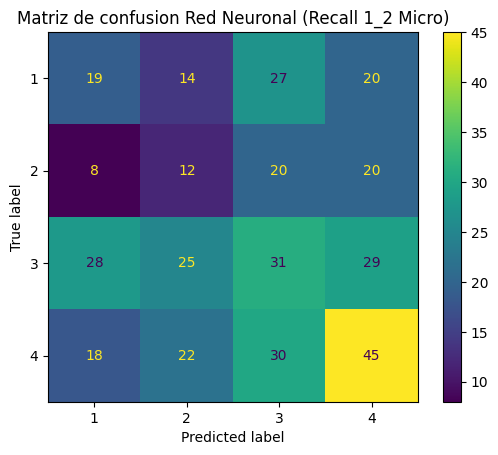

In [16]:
grid, y_test, y_pred = neural_network(satisfaction_df)

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, ConfusionMatrixDisplay

# Metricas
print('Accuracy (Test)', accuracy_score(y_test, y_pred))
print('Recall Micro Class 1, 2 (Test)', recall_score(y_test, y_pred, average = 'micro', labels=[1, 2]))

# Creacion de la matriz de confusion
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Graficar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title('Matriz de confusion Red Neuronal (Recall 1_2 Micro)')
plt.show()

Se puede observar que ninguno de los dos modelos llega a una exactitud considerable. De los modelos y configuraciones probados, la red neuronal `neural_network()` fue la que mas destaco con casi un 30% de exactitud (accuracy). Adicional, los parametros y modelos que estan en este script **no fueron los unicos evaluados**. Teniendo en cuenta que con la muestra de datos dada se puede lograr mas de 30% de exactitud prediciendo todo como nivel 4, esta exactitud no es buena.

A pesar de lo anterior, para nuestra aplicacion no es necesario tener un precision y exactitud alta. Lo mas importante de esta tarea de conocer los niveles de satisfaccion es poder identificar trabajadores con niveles de satisfaccion bajos para poder intervenir. Entonces, es mas importante que el modelo no sobrestime el nivel de satisfaccion y que identifique correctamente los  que tienen un nivel de satisfaccion bajo. Es por esto que los hiperparametros de cada modelo estan optimizados para lograr el mayor recall en los niveles de satisfaccion bajos. Es decir, minimizar los falsos negativos de la clase 1 y por consiguiente evitar lo mas posible clasificar a alguien con nivel alto de satisfaccion cuando no lo es.

Teniendo en cuenta lo anterior, podemos detectar hasta el **22%** de las personas con poca satisfaccion (nivel 1 o 2) en el trabajo con exactitud con el segundo modelo para poder intervenir a tiempo. Sin embargo no todos los clasificados en estos niveles presentan poca satisfaccion, adicional si bien el modelo predice mejor los niveles 3 y 4 lo mejor es decir que el modelo no es concluyente para estos niveles y asi no creer que alguien está satisfecho con el trabajo cuando no lo está.

En caso de que el modelo esté **desplegado** se podría hacer monitoreo del mismo de la siguiente forma:

En primer lugar, es crucial establecer una metrica clave que permita medir el desempeño del modelo en tiempo real. En este caso, se seleccionó el recall macro de los niveles 1 y 2. No obstante, esta medida debe estar en alineada con los objetivos de la empresa y debe revisarse con frecuencia.
Una vez se tenga definida la metrica clave, se debe crear un proceso de monitoreo continuo y automatizado que posibilite identificar y corregir cualquier problema o desviación en el desempeño del modelo. Por ejemplo, se pueden programar alertas que notifiquen a los equipos de datos o de ingeniería en caso de que el modelo presente un rendimiento inferior al esperado.
Asimismo, se pueden emplear técnicas avanzadas de monitoreo, como la interpretación de los resultados del modelo y el análisis de sensibilidad, con el fin de comprender mejor el modelo.

#### Victor A. Castro di Filippo - victoralcadi@hotmail.com